## Plot observed and modeled LFM at sites with overlapping observation records
Last updated: Kevin Varga, 12/11/2024

**Inputs:**
* CSV of observed and predicted LFM of all fuels at all sites

**Outputs:**
* Plot of 9 sites with temporally overlapping observation records

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [11]:
obs_path = '/home/sbarc/students/varga/nasa/ch1/data/lfm_model/stats/'
output_path = '/home/sbarc/students/varga/nasa/ch1/figures/sites/'

In [3]:
# Read in LFM observations, predictions and bias corrections at observation sites
predict_df = pd.read_csv(obs_path + 'all_fuels_obs_predictions.csv', index_col=['fuel','site','date'],
                         parse_dates=True, infer_datetime_format=True)
# Subset for chamise
fuel_type = 'chamise'
fuel_df = predict_df.loc[fuel_type]

# Extract site names
sites = pd.unique(fuel_df.index.get_level_values('site').unique())

In [4]:
# Determine start and end dates of each site's observation record
# Group by site and calculate the first and last dates
obs_df = pd.DataFrame(fuel_df['observed'].dropna())
site_df = obs_df.groupby('site').apply(
    lambda group: pd.Series({
        'start_date': group.index.get_level_values('date').min(),
        'end_date': group.index.get_level_values('date').max()
    })
)

# Reset the index to make site the index
site_df = site_df.reset_index().set_index('site')

# Find the sites that include data from the latest decade
overlap_df = site_df.loc[(site_df['start_date'] < '2009-02-01') & (site_df['end_date'] > '2019-05-15')]

# Determine overlapping sites, latest start date, and earliest end date
overlapping_sites = overlap_df.index.values
start_date = overlap_df['start_date'].max()
end_date = overlap_df['end_date'].min()

# Remove two sites that are missing data during time period
overlapping_sites = overlapping_sites[(overlapping_sites != 'templin_highway') &
                                      (overlapping_sites != 'laguna_ridge_casitas')]

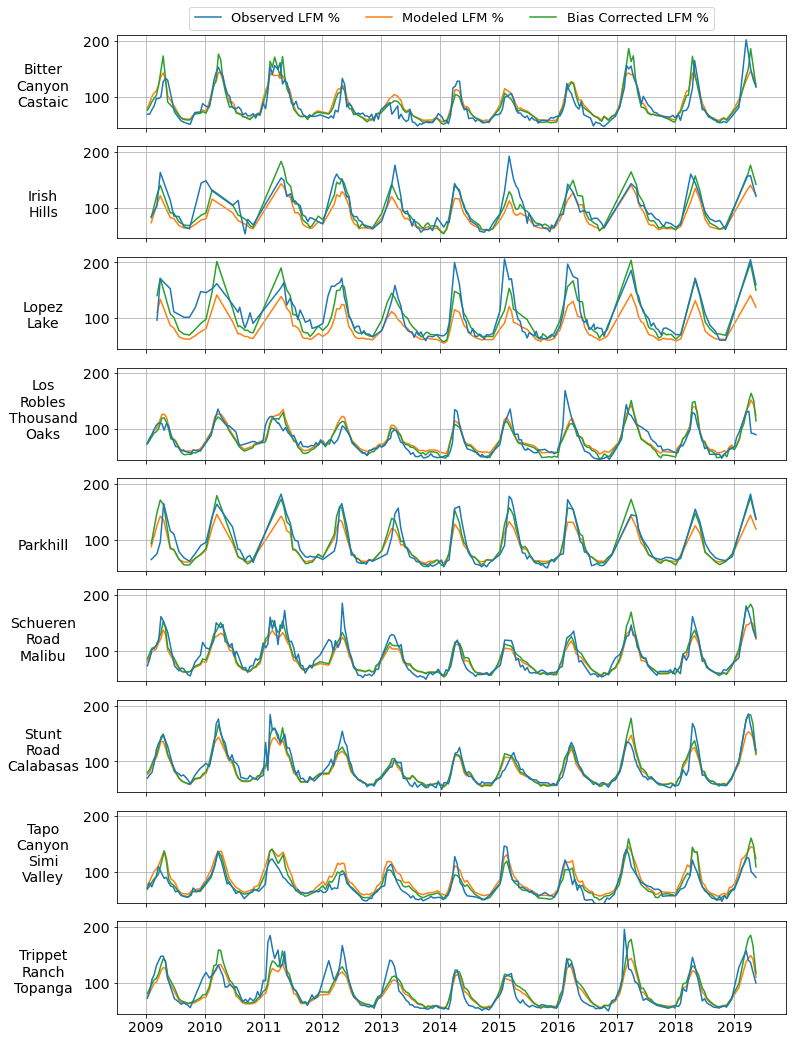

In [12]:
# Filter the DataFrame
filtered_df = fuel_df.loc[(overlapping_sites,slice(start_date,end_date)),:]

# Create a figure with subplots
fig, axs = plt.subplots(len(overlapping_sites), 1, figsize=(12, 18), sharex=True, facecolor='white')

# Plot each site's data
for i, site in enumerate(overlapping_sites):
    # Subset site data
    site_data = filtered_df.loc[site]
    # Subset observations and remove nan values for smoother plotting
    obs_data = site_data['observed'].dropna()
    # Plot observations
    axs[i].plot(obs_data.index.get_level_values('date'), obs_data, label='Observed LFM %', zorder=3)
    #axs[i].plot(site_data.index.get_level_values('date'), site_data['observed'], label='Observed LFM %')
    # Plot model values
    axs[i].plot(site_data.index.get_level_values('date'), site_data['no_bias_correction'], label='Modeled LFM %', zorder=1)
    axs[i].plot(site_data.index.get_level_values('date'), site_data['predicted'], label='Bias Corrected LFM %', zorder=2)
    # Set y-axis limits
    axs[i].set_ylim(45,210)    
    # Set y-axis label using site name
    axs[i].set_ylabel(site.replace('_','\n').title(), rotation='horizontal', fontsize=14)
    # Set location of y label
    axs[i].yaxis.set_label_coords(-0.11, 0.2)
    # Set x-axis labels to be every year
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axs[i].xaxis.set_major_locator(mdates.YearLocator(1))
    # Set tick fonts
    axs[i].tick_params(axis='y', labelsize=14) #, labelweight='bold')
    axs[i].tick_params(axis='x', labelsize=14)
    # Create grid
    axs[i].grid(True)

# Create legend only on the first plot
axs[0].legend(fontsize=13, ncol=3, bbox_to_anchor=(0.5, 1.05), loc='lower center', borderaxespad=0.05)

# Show and save the plot
plt.show()
fig.savefig(output_path + 'chamise/9-sites-2009-19.png', dpi = 600, bbox_inches='tight');